<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/SectorPerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.simplefilter(action='ignore', category=Warning)


In [117]:
data = pd.read_csv('/content/gold.csv')

data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

del data['time']


In [118]:
data.tail(2)

,close,CNXFMCG · NSE: close,BANKNIFTY · NSE: close,CNXAUTO · NSE: close,CNXMETAL · NSE: close,CNXPHARMA · NSE: close,CNXIT · NSE: close,GOLDBEES · NSE: close,Volume,date
2395,24809.05,61225.352,52620.699,25576.699,9636.9502,20768.35,40010.398,62.91,9438225,18-07-2024
2396,24529.85,61087.898,52265.602,24963.350,9256.2998,20425.40,39923.301,62.41,8005525,19-07-2024


In [119]:
data = data.rename(columns={
    'CNXAUTO · NSE: close': 'Auto',
    'CNXMETAL · NSE: close': 'Metal',
    'CNXPHARMA · NSE: close': 'Pharma',
    'CNXIT · NSE: close': 'IT',
    'GOLDBEES · NSE: close': 'Gold',
    'closeVolume': 'Volume',
    'close':'Nifty',
    'CNXFMCG · NSE: close': 'FMCG',
    'BANKNIFTY · NSE: close': 'Bank',
    'date': 'Date'
})

In [122]:
data.tail(2)

,Nifty,FMCG,Bank,Auto,Metal,Pharma,IT,Gold,Volume
Date,,,,,,,,,
18-07-2024,24809.05,61225.352,52620.699,25576.699,9636.9502,20768.35,40010.398,62.91,9438225
19-07-2024,24529.85,61087.898,52265.602,24963.350,9256.2998,20425.40,39923.301,62.41,8005525


In [120]:
data=data.set_index('Date')

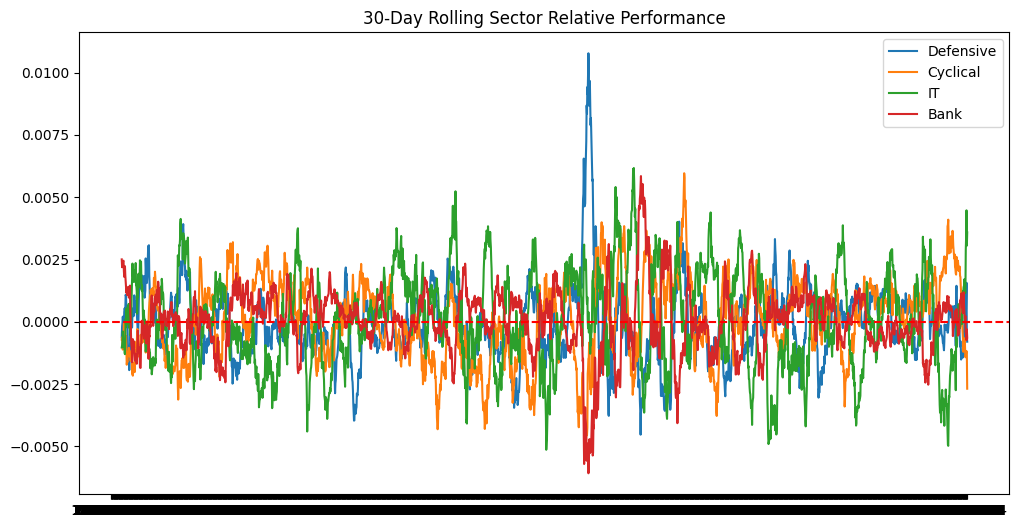

Regime Distribution:
Regime
Neutral     0.500209
Risk-On     0.309554
Risk-Off    0.190238
Name: proportion, dtype: float64

Recent Regimes:
Date
12-07-2024    Risk-Off
15-07-2024    Risk-Off
16-07-2024    Risk-Off
18-07-2024     Neutral
19-07-2024     Neutral
Name: Regime, dtype: object


In [123]:
def calculate_relative_performance(data, benchmark):
    returns = data.pct_change()
    relative_perf = returns.sub(returns[benchmark], axis=0)
    return relative_perf

def rolling_sector_strength(relative_perf, window=30):
    return relative_perf.rolling(window).mean()

def identify_regime(row, threshold=0.00001):
    if row['Cyclical'] > threshold and row['Defensive'] < -threshold:
        return 'Risk-On'
    elif row['Cyclical'] < -threshold and row['Defensive'] > threshold:
        return 'Risk-Off'
    else:
        return 'Neutral'

def plot_sector_performance(sector_strength):
    plt.figure(figsize=(12, 6))
    for column in sector_strength.columns:
        plt.plot(sector_strength.index, sector_strength[column], label=column)
    plt.title('30-Day Rolling Sector Relative Performance')
    plt.legend()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

sectors = {
    'Benchmark': 'Nifty',  # Nifty 50
    'Defensive': ['Pharma','FMCG'],
    'Cyclical': ['Auto', 'Metal'],
    'Technology': 'IT',
    'Financial': 'Bank'
}


# Fetch data
#data = fetch_sector_data([sectors['Benchmark']] + sectors['Defensive'] + sectors['Cyclical'] + [sectors['Financial'], sectors['Technology']], start_date, end_date)

# Calculate relative performance
relative_perf = calculate_relative_performance(data, sectors['Benchmark'])

# Calculate rolling sector strength
sector_strength = rolling_sector_strength(relative_perf)

# Aggregate sector groups
sector_strength['Defensive'] = sector_strength[sectors['Defensive']].mean(axis=1)
sector_strength['Cyclical'] = sector_strength[sectors['Cyclical']].mean(axis=1)
sector_strength = sector_strength[['Defensive', 'Cyclical', 'IT','Bank']]

# Identify regimes
sector_strength['Regime'] = sector_strength.apply(identify_regime, axis=1)

# Plot sector performance
plot_sector_performance(sector_strength.drop('Regime', axis=1))

# Print regime distribution
print("Regime Distribution:")
print(sector_strength['Regime'].value_counts(normalize=True))

# Print recent regimes
print("\nRecent Regimes:")
print(sector_strength['Regime'].tail())



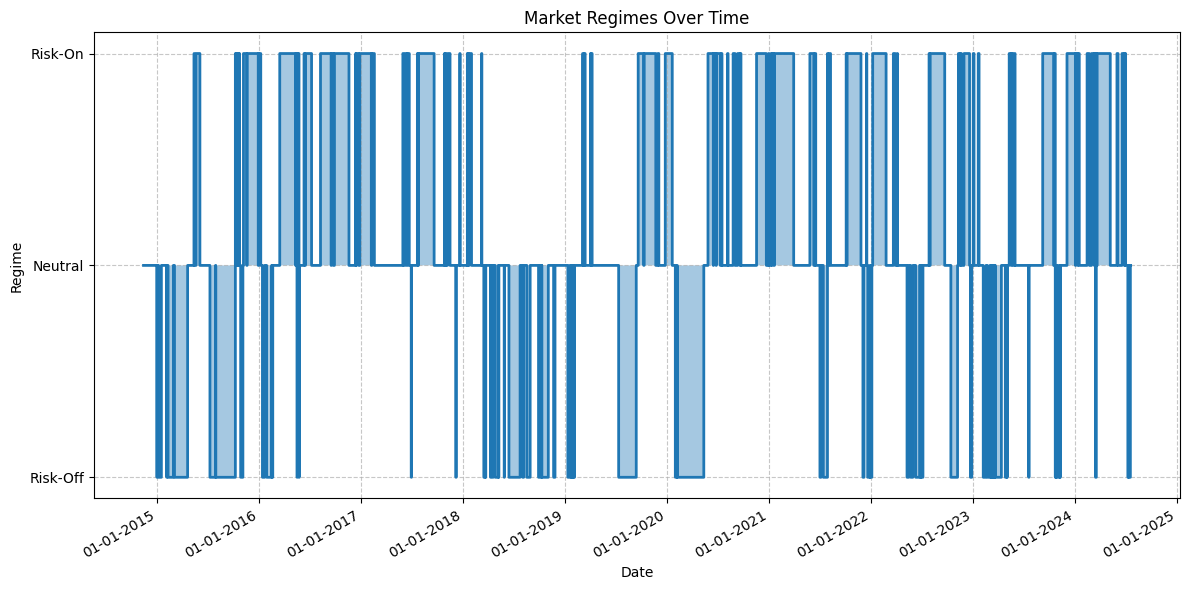

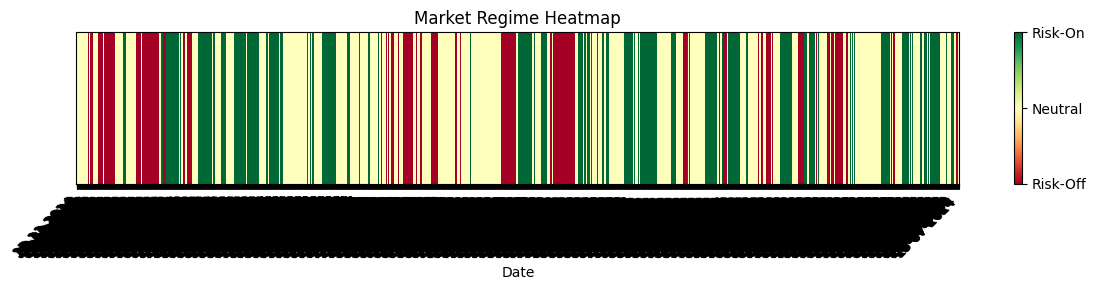

In [124]:
import matplotlib.dates as mdates
sector_strength = sector_strength.reset_index()
#sector_strength=sector_strength.tail(200)
# Ensure 'Date' column is in datetime format
sector_strength['Date'] = pd.to_datetime(sector_strength['Date'])

# Function to convert regime to numeric value
def regime_to_numeric(regime):
    if regime == 'Risk-On':
        return 1
    elif regime == 'Neutral':
        return 0
    else:  # Risk-Off
        return -1

sector_strength['Regime_Numeric'] = sector_strength['Regime'].apply(regime_to_numeric)

# Create a color-coded timeline
plt.figure(figsize=(12, 6))
plt.plot(sector_strength['Date'], sector_strength['Regime_Numeric'], drawstyle='steps-post', linewidth=2)
plt.fill_between(sector_strength['Date'], sector_strength['Regime_Numeric'], step='post', alpha=0.4)

plt.title('Market Regimes Over Time')
plt.xlabel('Date')
plt.ylabel('Regime')

# Set y-axis ticks and labels
plt.yticks([-1, 0, 1], ['Risk-Off', 'Neutral', 'Risk-On'])

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a color-coded heatmap
plt.figure(figsize=(12, 3))
plt.imshow([sector_strength['Regime_Numeric']], cmap='RdYlGn', aspect='auto', interpolation='nearest')

plt.title('Market Regime Heatmap')
plt.xlabel('Date')
plt.yticks([])  # Hide y-axis labels

# Set x-axis ticks and labels
plt.xticks(range(len(sector_strength)), sector_strength['Date'].dt.strftime('%d-%m-%Y'), rotation=45, ha='right')

# Add colorbar
cbar = plt.colorbar(ticks=[-1, 0, 1])
cbar.set_ticklabels(['Risk-Off', 'Neutral', 'Risk-On'])

plt.tight_layout()
plt.show()

In [125]:
sector_strength.tail(5)

,Date,Defensive,Cyclical,IT,Bank,Regime,Regime_Numeric
2392,2024-07-12,0.000025,-0.001363,0.002888,-0.000430,Risk-Off,-1
2393,2024-07-15,0.000693,-0.001241,0.003398,-0.000345,Risk-Off,-1
2394,2024-07-16,0.001569,-0.001170,0.004474,-0.000734,Risk-Off,-1
2395,2024-07-18,-0.000555,-0.001285,0.003057,-0.000300,Neutral,0
2396,2024-07-19,-0.000796,-0.002682,0.003591,-0.000632,Neutral,0


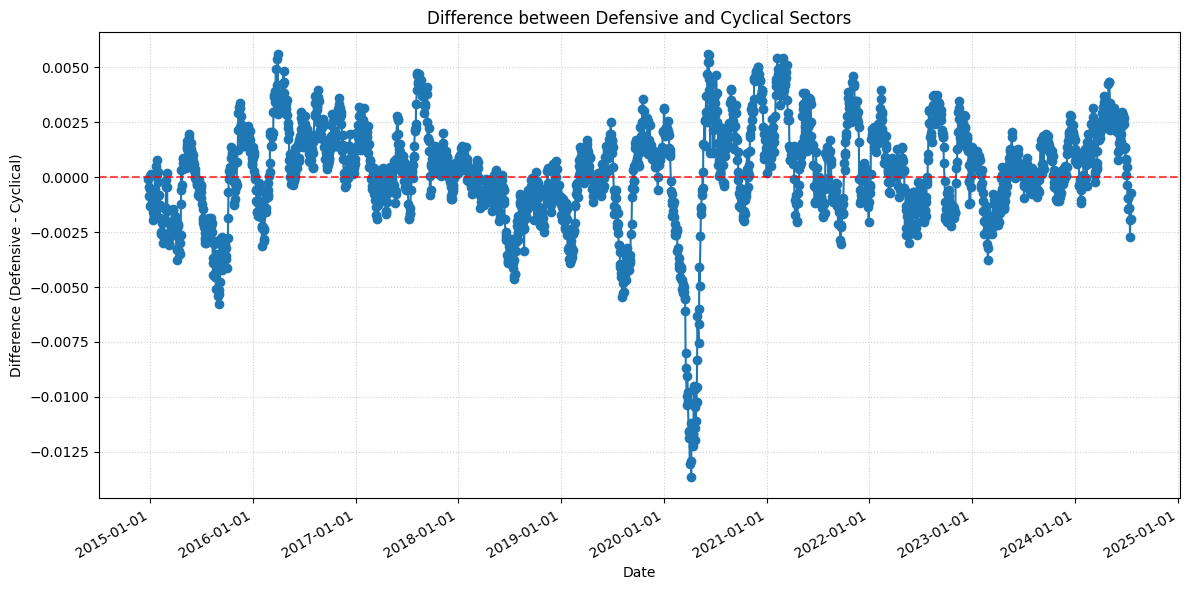

In [126]:

# Convert Date to datetime
sector_strength['Date'] = pd.to_datetime(sector_strength['Date'])

# Calculate the difference
sector_strength['Difference'] = -(sector_strength['Defensive'] - sector_strength['Cyclical'])

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(sector_strength['Date'], sector_strength['Difference'], marker='o')

# Customize the plot
plt.title('Difference between Defensive and Cyclical Sectors')
plt.xlabel('Date')
plt.ylabel('Difference (Defensive - Cyclical)')

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add a horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

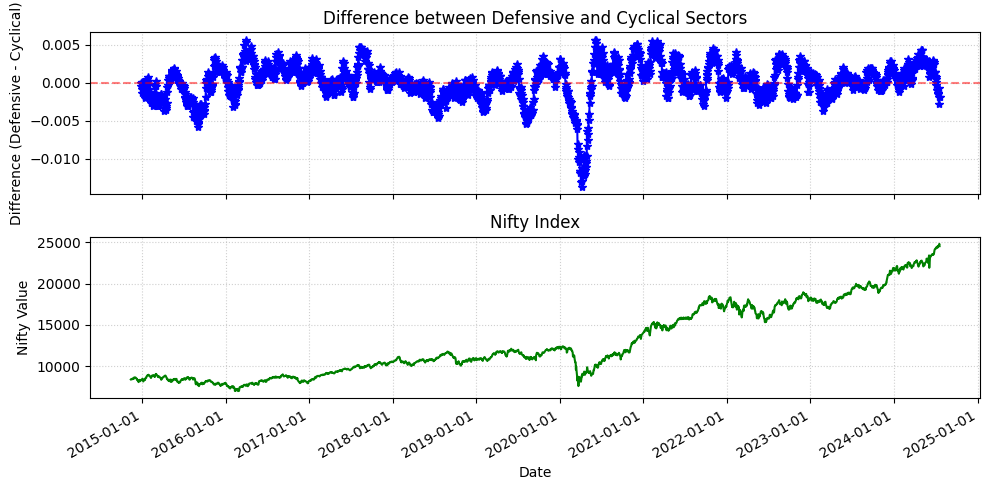

In [128]:
data=data.reset_index()
# Assuming sector_strength and data DataFrames are already loaded
# Convert Date to datetime if not already done
sector_strength['Date'] = pd.to_datetime(sector_strength['Date'])
data['Date'] = pd.to_datetime(data['Date'])

# Merge the DataFrames
merged_data = pd.merge(sector_strength, data[['Date', 'Nifty']], on='Date', how='inner')

# Calculate the difference
merged_data['Difference'] = (merged_data['Defensive'] - merged_data['Cyclical'])*-1

# Create the plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True)

# Plot the difference on the first subplot
ax1.plot(merged_data['Date'], merged_data['Difference'], marker='*',color='blue')
ax1.set_title('Difference between Defensive and Cyclical Sectors')
ax1.set_ylabel('Difference (Defensive - Cyclical)')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.grid(True, linestyle=':', alpha=0.6)

# Plot Nifty on the second subplot
ax2.plot(merged_data['Date'], merged_data['Nifty'], color='green')
ax2.set_title('Nifty Index')
ax2.set_xlabel('Date')
ax2.set_ylabel('Nifty Value')
ax2.grid(True, linestyle=':', alpha=0.6)

# Format x-axis to show dates nicely
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()  # Rotate and align the tick labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [131]:
data=data.tail(500)
sector_strength=sector_strength.tail(500)

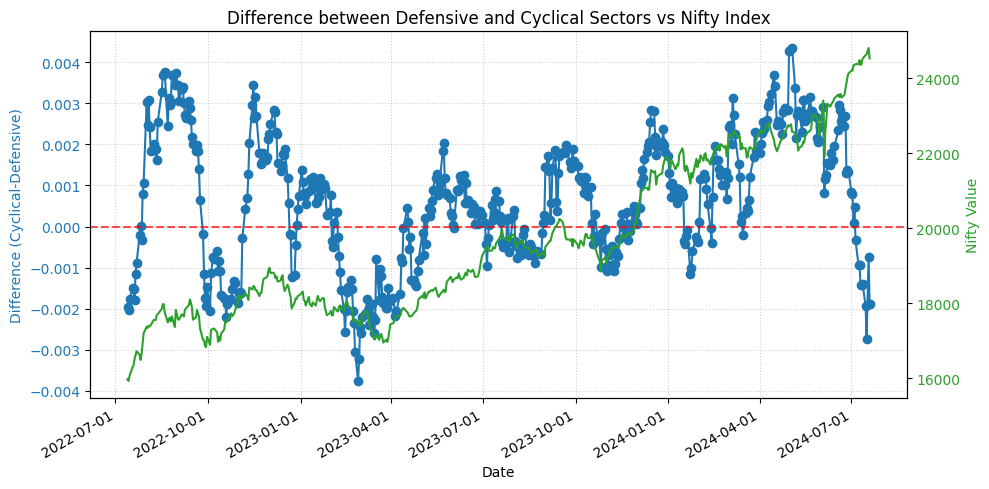

In [133]:

# Assuming sector_strength and data DataFrames are already loaded
# Convert Date to datetime if not already done
sector_strength['Date'] = pd.to_datetime(sector_strength['Date'])
data['Date'] = pd.to_datetime(data['Date'])

# Merge the DataFrames
merged_data = pd.merge(sector_strength, data[['Date', 'Nifty']], on='Date', how='inner')

# Calculate the difference
merged_data['Difference'] = merged_data['Cyclical'] - merged_data['Defensive']

# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot the difference on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Difference (Cyclical-Defensive)', color=color)
ax1.plot(merged_data['Date'], merged_data['Difference'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.7)

# Create a secondary y-axis and plot Nifty on it
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Nifty Value', color=color)
ax2.plot(merged_data['Date'], merged_data['Nifty'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the title
plt.title('Difference between Defensive and Cyclical Sectors vs Nifty Index')

# Format x-axis to show dates nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()  # Rotate and align the tick labels

# Add grid for better readability
ax1.grid(True, linestyle=':', alpha=0.6)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()